# École Polytechnique de Montréal
Département Génie Informatique et Génie Logiciel
INF8460 – Traitement automatique de la langue naturelle

### Prof. Amal Zouaq
### Chargé de laboratoire: Félix Martel


# INF8460 - TP2

## Objectifs

•	Explorer les modèles d’espaces vectoriels comme représentations distribuées de la sémantique des mots et des documents

•	Comprendre différentes mesures de distance entre vecteurs de documents et de mots

•	Utiliser un modèle de langue n-gramme de caractères et l’algorithme Naive Bayes pour l’analyse de sentiments dans des revues de films (positives, négatives)


## 1. Prétraitement

Le jeu de données est séparé en deux répertoires `train/`et `test`, chacun contenant eux-mêmes deux sous-répertoires `pos/` et `neg/` pour les revues positives et négatives. Un fichier `readme` décrit plus précisément les données.

Commencez par lire ces données, en gardant séparées les données d'entraînement et de test.

In [1]:
import os
import re
import nltk
import collections
import math
import itertools
import time
import copy
import numpy as np
from scipy.spatial import distance
from nltk.corpus import stopwords
nltk.download('stopwords')

global dictionnaire
# notre dictionnaire de donnée aura cette forme là
dictionnaire = {
    "test": {"pos": {},
            "neg": {}},
    "train": {"pos": {},
            "neg": {}}
}

nb_failed_files = 0
for train_type in ["test", "train"]:
    for classification in ["pos", "neg"]:
        path = './data/' + train_type + '/' + classification + '/'
        for file in os.listdir(path):
            id_review, rate_review = file.split("_")
            rate_review = rate_review.split(".txt")[0]
            if int(id_review) not in dictionnaire[train_type][classification]:
                with open(path + file, "r") as f:
                    try:
                        dictionnaire[train_type][classification][int(id_review)] = { "rate": int(rate_review), "review_str": f.read()}
                    except:
                        nb_failed_files += 1

print("Nombre de fichiers non-ouverts : " + str(nb_failed_files))
init_dictionnaire = copy.deepcopy(dictionnaire)

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/gregoire/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Nombre de fichiers non-ouverts : 0


**a)** Créez la fonction `clean_doc()` qui effectue les pré-traitements suivants : segmentation en mots ; 
suppression des signes de ponctuations ; suppression des mots qui contiennent des caractères autres qu’alphabétiques ; 
suppression des mots qui sont connus comme des stop words ; suppression des mots qui ont une longueur de 1 caractère. Ensuite, appliquez-la à vos données.

Les stop words peuvent être obtenus avec `from nltk.corpus import stopwords`. Vous pourrez utiliser des [expressions régulières](https://docs.python.org/3.7/howto/regex.html).

In [2]:
def clean_doc(dictio):

    for type_dataset in dictio:
        for sentiment_type in dictio[type_dataset]:
            for id_review in dictio[type_dataset][sentiment_type]:
                # on va d'abord filtrer les caractères spéciaux
                review = dictio[type_dataset][sentiment_type][id_review]["review_str"]
                review = review.translate ({ord(c): " " for c in "!@#$%^&*()[]{};:,./?\|`~-=_+"})
                # on sépare les mots
                review = review.split()
                # on selectionne les mots qui ne sont pas des stop words
                stop_words = set(stopwords.words('english'))
                review_list = [w for w in review if not w in stop_words]
                segmentize_review = []

                for word in review_list:
                    if(re.match('^[a-zA-Z]+$', word) and len(word)>1):
                        segmentize_review.append(word)

                dictio[type_dataset][sentiment_type][id_review]["review"] = segmentize_review



clean_doc(dictionnaire)
print("exemple: \n")
print(dictionnaire["test"]["pos"][0]["review"])

exemple: 

['went', 'saw', 'movie', 'last', 'night', 'coaxed', 'friends', 'mine', 'admit', 'reluctant', 'see', 'knew', 'Ashton', 'Kutcher', 'able', 'comedy', 'wrong', 'Kutcher', 'played', 'character', 'Jake', 'Fischer', 'well', 'Kevin', 'Costner', 'played', 'Ben', 'Randall', 'professionalism', 'The', 'sign', 'good', 'movie', 'toy', 'emotions', 'This', 'one', 'exactly', 'The', 'entire', 'theater', 'sold', 'overcome', 'laughter', 'first', 'half', 'movie', 'moved', 'tears', 'second', 'half', 'While', 'exiting', 'theater', 'saw', 'many', 'women', 'tears', 'many', 'full', 'grown', 'men', 'well', 'trying', 'desperately', 'let', 'anyone', 'see', 'crying', 'This', 'movie', 'great', 'suggest', 'go', 'see', 'judge']


**b)**	Créez la fonction `build_voc()` qui extrait les unigrammes de l’ensemble d’entraînement et conserve ceux qui ont une fréquence d’occurrence de 5 au moins et imprime le nombre de mots dans le vocabulaire. Sauvegardez-le dans un fichier `vocab.txt` (un mot par ligne).

In [3]:
def build_voc(dico_train):
    count = collections.defaultdict(lambda: 0)
    for classi in dico_train:
        for review in dico_train[classi]:
            text = dico_train[classi][review]["review"]
            for word in text:
                if word in count:
                    count[word] += 1
                else:
                    count[word] = 1
    n = 0
    f = open("./data/vocab.txt", "w+")
    for word in count:
        if count[word] >= 5:
            n += 1
            f.write(word + "\n")
    print("Nombre de mots dans le vocabulaire : " + str(n))
    f.close()
    return n

taille_voc = build_voc(dictionnaire["train"])

Nombre de mots dans le vocabulaire : 31558


**c)** Vous devez créer une fonction `get_top_unigrams(n)` qui retourne les $n$ unigrammes les plus fréquents et les affiche, puis l'appeler avec $n=10$.

In [4]:
def get_top_unigrams(n):

    dico_count = {}

    for train_type in ["test", "train"]:
        for classification in ["pos", "neg"]:
            for review in dictionnaire[train_type][classification]:
                for word in dictionnaire[train_type][classification][review]['review']:
                    if word not in dico_count:
                        dico_count[word] = 1
                    else:
                        dico_count[word] += 1
    
    # on se base sur un counter, bien plus rapide
    counter = collections.Counter(dico_count)
    top_unigrams = counter.most_common(n)
    return [couple[0] for couple in top_unigrams]

**d)**	Vous devez créer une fonction `get_top_unigrams_per_cls(n, cls)` qui retourne les $n$ unigrammes les plus fréquents de la classe `cls` (pos ou neg) et les affiche.

In [5]:
def get_top_unigrams_per_cls(n, cls):
    dico_count = {}

    for train_type in ["test", "train"]:
        for review in dictionnaire[train_type][cls]:
            for word in dictionnaire[train_type][cls][review]['review']:
                if word not in dico_count:
                    dico_count[word] = 1
                else:
                    dico_count[word] += 1
    # idem
    counter = collections.Counter(dico_count)
    top_unigrams = counter.most_common(n)
    return [couple[0] for couple in top_unigrams]

**e)**	Affichez les 10 unigrammes les plus fréquents dans la classe positive :

In [6]:
print(get_top_unigrams_per_cls(10, "pos"))

['film', 'movie', 'The', 'one', 'like', 'good', 'This', 'time', 'story', 'great']


**f)**	Affichez les 10 unigrammes les plus fréquents dans la classe négative :

In [7]:
print(get_top_unigrams_per_cls(10, "neg"))

['movie', 'film', 'The', 'one', 'like', 'good', 'bad', 'would', 'even', 'This']


## 2. Matrices de co-occurence

Pour les matrices de cette section, vous pourrez utiliser [des array `numpy`](https://docs.scipy.org/doc/numpy/reference/arrays.ndarray.html) ou des DataFrame [`pandas`](https://pandas.pydata.org/pandas-docs/stable/). 

Ressources utiles :  le [*quickstart tutorial*](https://numpy.org/devdocs/user/quickstart.html) de numpy et le guide [10 minutes to pandas](https://pandas.pydata.org/pandas-docs/stable/getting_started/10min.html).

### 2.1 Matrice document × mot et TF-IDF


Soit $X \in \mathbb{R}^{m \times n}$ une matrice de $m$ documents et $n$ mots, telle que $X_{i,j}$ contient la fréquence d'occurrence du terme $j$ dans le document $i$ :

$$\textbf{rowsum}(X, d) = \sum_{j=1}^{n}X_{dj}$$

$$\textbf{TF}(X, d, t) = \frac{X_{d,t}}{\textbf{rowsum}(X, d)}$$

$$\textbf{IDF}(X, t) = \log\left(\frac{m}{|\{d : X_{d,t} > 0\}|}\right)$$

$$\textbf{TF-IDF}(X, d, t) = \textbf{TF}(X, d, t) \cdot \textbf{IDF}(X, t)$$


En utilisant le même vocabulaire de 5 000 unigrammes, vous devez représenter les documents dans une matrice de co-occurrence document × mot $M(d, w)$  et les pondérer avec la mesure TF-IDF.

In [8]:
unigrams = get_top_unigrams(5000)
print("les 5000 premiers unigrams")
print(unigrams[0:30])
debut_mm = time.time()
BoW = np.array([])
for train_type in ["test", "train"]:
    for classification in ["pos", "neg"]:
        # on construit un BoW vide, pour chaque classe et type
        # pour éviter les appends à chaque nouvelle ligne et profiter des types numpy
        BoW_part = np.zeros((len(dictionnaire[train_type][classification]), len(unigrams)))
        for index, review in enumerate(dictionnaire[train_type][classification]):
            for word in dictionnaire[train_type][classification][review]['review']:
                if word in unigrams:
                    BoW_part[index, unigrams.index(word)] += 1
        # on construit la grande matrice à partir des 4 précédentes
        BoW = np.append(BoW, BoW_part, axis=0) if BoW.size != 0 else BoW_part

print("\nBag of Word")
print("fait en : " + str(time.time() - debut_mm) + "s")
print(BoW)

debut_mm = time.time()
TFIDF_BoW = BoW.copy()
# liste des idf par index (cf unigrams)
idf = []
for i,_ in enumerate(unigrams):
    dfi = 0
    for j in range(TFIDF_BoW.shape[0]):
        # on compte le nombre de documents qui contiennent ce mot
        dfi += 1 if TFIDF_BoW[j, i] != 0 else 0
    # on calcul et ajoute le idf à la liste des idf
    idf.append(math.log(TFIDF_BoW.shape[0] / dfi))

# on modifie la matrice
for j in range(TFIDF_BoW.shape[0]):
    for i, _ in enumerate(unigrams):
        value = TFIDF_BoW[j, i] * idf[i]
        TFIDF_BoW[j, i] = value
print("\nBag of Word TFIDF")
print("fait en : " + str(time.time() - debut_mm) + "s")
print(TFIDF_BoW)

les 5000 premiers unigrams
['movie', 'film', 'The', 'one', 'like', 'good', 'This', 'time', 'would', 'really', 'story', 'see', 'It', 'even', 'much', 'well', 'get', 'bad', 'people', 'great', 'made', 'first', 'make', 'also', 'way', 'could', 'movies', 'think', 'characters', 'films']

Bag of Word
fait en : 179.48207807540894s
[[6. 4. 1. ... 0. 0. 0.]
 [2. 0. 5. ... 0. 0. 0.]
 [0. 2. 0. ... 0. 0. 0.]
 ...
 [1. 4. 0. ... 0. 0. 0.]
 [3. 0. 0. ... 0. 0. 0.]
 [0. 2. 2. ... 0. 0. 0.]]

Bag of Word TFIDF
fait en : 235.26119875907898s
[[3.03920905 2.41878736 0.45532785 ... 0.         0.         0.        ]
 [1.01306968 0.         2.27663924 ... 0.         0.         0.        ]
 [0.         1.20939368 0.         ... 0.         0.         0.        ]
 ...
 [0.50653484 2.41878736 0.         ... 0.         0.         0.        ]
 [1.51960453 0.         0.         ... 0.         0.         0.        ]
 [0.         1.20939368 0.91065569 ... 0.         0.         0.        ]]


### 2.2 Matrice mot × mot et PPMI (*positive pointwise mutual information*)

Vous devez calculer la métrique PPMI. Pour une matrice $m \times n$ $X$ :


$$\textbf{colsum}(X, j) = \sum_{i=1}^{m}X_{ij}$$

$$\textbf{sum}(X) = \sum_{i=1}^{m}\sum_{j=1}^{n} X_{ij}$$

$$\textbf{expected}(X, i, j) = 
\frac{
  \textbf{rowsum}(X, i) \cdot \textbf{colsum}(X, j)
}{
  \textbf{sum}(X)
}$$


$$\textbf{pmi}(X, i, j) = \log\left(\frac{X_{ij}}{\textbf{expected}(X, i, j)}\right)$$

$$\textbf{ppmi}(X, i, j) = 
\begin{cases}
\textbf{pmi}(X, i, j) & \textrm{if } \textbf{pmi}(X, i, j) > 0 \\
0 & \textrm{otherwise}
\end{cases}$$


**a)**	A partir des textes du corpus d’entrainement (neg *et* pos), vous devez construire une matrice de co-occurrence mot × mot $M(w,w)$ qui contient les 5000 unigrammes les plus fréquents. 

In [9]:
debut_mm = time.time()
# on initialise la matrice
matrice_MM = np.zeros((len(unigrams), len(unigrams)))
for train_type in ["test", "train"]:
    for classification in ["pos", "neg"]:
        for review in dictionnaire[train_type][classification]:
            # on selectionne seulement les mots qui font parti des 5000 selectionnés
            words_to_consider  = list(set(unigrams).intersection(dictionnaire[train_type][classification][review]['review']))
            # on préfère manipuler les index pour ne pas à avoir à chercher dans la liste des mots
            index_to_consider = [unigrams.index(couple_word) for couple_word in words_to_consider]
            # on génère tout les couples possibles à partir des index des mots présents
            permutation = itertools.permutations(index_to_consider, 2)
            # on met à jour la matrice
            for index_to_consider in permutation:
                matrice_MM[index_to_consider] += 1

print("matrice_MM")
print("fait en : " + str(time.time() - debut_mm) + "s")
print(matrice_MM)

matrice_MM
fait en : 264.3557562828064s
[[    0. 15033. 19527. ...    87.    73.    66.]
 [15033.     0. 18600. ...    96.   109.    72.]
 [19527. 18600.     0. ...   121.   112.    93.]
 ...
 [   87.    96.   121. ...     0.     0.     0.]
 [   73.   109.   112. ...     0.     0.     0.]
 [   66.    72.    93. ...     0.     0.     0.]]


**b)**	Vous devez créer une fonction `calculate_PPMI` qui prend la matrice $M(w,w)$ et la transforme en une matrice $M’(w,w)$ avec les valeurs PPMI.

In [10]:
debut_mm = time.time()
def calculate_PPMI(matrice_MM):
    colsum = np.sum(matrice_MM, axis=0)
    row_sum = np.sum(matrice_MM, axis=1)
    sum = np.sum(matrice_MM)
    expected = np.zeros((matrice_MM.shape[0], matrice_MM.shape[1]))
    ppmi =  np.zeros((matrice_MM.shape[0], matrice_MM.shape[1]))
    for index,_ in np.ndenumerate(expected):
        expected[index] = (row_sum[index[0]] * colsum[index[1]]) / sum
        pmi = math.log(matrice_MM[index] / expected[index]) if matrice_MM[index] > 0 else 0
        ppmi[index] = pmi if pmi > 0 else 0

    return ppmi

print("matrice_PPMI")
matrice_PPMI = calculate_PPMI(matrice_MM)
print("fait en : " + str(time.time() - debut_mm) + "s")
print(matrice_PPMI)

matrice_PPMI
fait en : 35.39947843551636s
[[0.         0.09212505 0.20809633 ... 0.         0.         0.        ]
 [0.09212505 0.         0.14769804 ... 0.         0.         0.        ]
 [0.20809633 0.14769804 0.         ... 0.00283198 0.         0.07636374]
 ...
 [0.         0.         0.00283198 ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.07636374 ... 0.         0.         0.        ]]


## 3. Mesures de similarité

En utilisant le module [scipy.spatial.distance](https://docs.scipy.org/doc/scipy/reference/spatial.distance.html),  définissez des fonctions pour calculer les métriques suivantes :

**Distance Euclidienne**

La distance euclidienne entre deux vecteurs $u$ et $v$ de dimension $n$ est

$$\textbf{euclidean}(u, v) = 
\sqrt{\sum_{i=1}^{n}|u_{i} - v_{i}|^{2}}$$

En deux dimensions, cela correspond à la longueur de la ligne droite entre deux points.

**a)** Implémentez la fonction `get_euclidean_distance(v1 ,v2)` qui retourne la distance euclidienne entre les vecteurs v1 et v2.

In [11]:
def get_euclidean_distance(v1 ,v2):
    return distance.euclidean(v1, v2)

**Distance Cosinus**


La distance cosinus entre deux vecteurs $u$ et $v$ de dimension $n$ s'écrit :

$$\textbf{cosine}(u, v) = 
1 - \frac{\sum_{i=1}^{n} u_{i} \cdot v_{i}}{\|u\|_{2} \cdot \|v\|_{2}}$$

Le terme de droite dans la soustraction mesure l'angle entre $u$ et $v$; on l'appelle la *similarité cosinus* entre $u$ et $v$.

**b)** Implémentez la fonction `get_cosinus_distance(v1, v2)` qui retourne la distance cosinus entre les vecteurs v1 et v2.

In [12]:
def get_cosinus_distance(v1, v2):
    return distance.cosine(v1, v2)

**c)** Implémentez la fonction `get_most_similar_PPMI(word, metric, n)` qui prend un mot en entrée et une mesure de distance et qui retourne les n mots les plus similaires selon la mesure. Les mesures à tester sont : la distance euclidienne et la distance cosinus implantées ci-dessus. Le vecteur du mot word doit être extrait de la matrice $M’(w,w)$.

In [13]:
def get_most_similar_PPMI(word, metric, n):
    index_word = unigrams.index(word)
    ligne_word = matrice_PPMI[index_word]
    vector_distance = {}
    i = 0
    if metric == "cosinus":
        for index, ligne in enumerate(matrice_PPMI):
            vector_distance[unigrams[index]] = get_cosinus_distance(ligne_word, ligne)
            i += 1
    elif metric == "euclidean":
        for index, ligne in enumerate(matrice_PPMI):
            vector_distance[unigrams[index]] = get_euclidean_distance(ligne_word, ligne)
            i += 1
    else:
        print("metric inconnue")

    counter = collections.Counter(vector_distance)
    top_unigrams = counter.most_common(n)
    return [couple[0] for couple in top_unigrams]

**d)** Trouvez les 5 mots les plus similaires au mot « bad » et affichez-les, pour chacune des deux distances. Commentez.

In [14]:
print("les mots les plus proches de \"bad\": ")
most_similar = get_most_similar_PPMI("bad", "euclidean", 15)
print(most_similar)

print("\nles mots les plus proches de \"bad\": ")
most_similar = get_most_similar_PPMI("bad", "cosinus", 15)
print(most_similar)

les mots les plus proches de "bad": 
['Custer', 'Streisand', 'Cagney', 'Bugs', 'Felix', 'Garfield', 'Karloff', 'Columbo', 'Barney', 'Frost', 'Matthau', 'Lincoln', 'Cinderella', 'Hart', 'Radio']

les mots les plus proches de "bad": 
['beautifully', 'beautiful', 'young', 'war', 'War', 'marriage', 'emotional', 'relationship', 'lives', 'journey', 'father', 'life', 'beauty', 'mother', 'wonderful']


*-> Commentez ici<-*

**e)** Implémentez la fonction `get_most_similar_TFIDF(word, metric, n)` qui prend un mot en entrée et une mesure de distance et qui retourne les n mots les plus similaires selon la mesure. Les mesures à tester sont : la distance euclidienne et la distance cosinus implantées ci-dessus. Le vecteur du mot word doit être extrait de la matrice $M(d,w)$.

In [15]:
def get_most_similar_TFIDF(word, metric, n):
    index_word = unigrams.index(word)
    column_word = TFIDF_BoW[:, index_word]
    vector_distance = {}
    if metric == "cosinus":
        for index, column in enumerate(TFIDF_BoW.T):
            vector_distance[unigrams[index]] = get_cosinus_distance(column_word, column)
    elif metric == "euclidean":
        for index, column in enumerate(TFIDF_BoW.T):
            vector_distance[unigrams[index]] = get_euclidean_distance(column_word, column)
    else:
        print("metric inconnue")

    counter = collections.Counter(vector_distance)
    top_unigrams = counter.most_common(n)
    return [couple[0] for couple in top_unigrams]

**f)** Trouvez les 5 mots les plus similaires au mot « bad » et affichez-les, pour chacune des deux distances. Commentez

In [16]:
print("les mots les plus proches de \"bad\": ")
most_similar = get_most_similar_TFIDF("bad", "euclidean", 15)
print(most_similar)

print("\nles mots les plus proches de \"bad\": ")
most_similar = get_most_similar_TFIDF("bad", "cosinus", 15)
print(most_similar)

les mots les plus proches de "bad": 
['show', 'game', 'match', 'Batman', 'series', 'book', 'Custer', 'Bond', 'Holmes', 'war', 'THE', 'horror', 'film', 'episode', 'Tarzan']

les mots les plus proches de "bad": 
['Felix', 'Cassavetes', 'Bugs', 'Scarlett', 'Custer', 'Matthau', 'Lemmon', 'Heart', 'Streisand', 'Garfield', 'Stanwyck', 'Bourne', 'Jesse', 'Le', 'Holly']


## 4. Classification de documents avec un modèle de langue

En vous inspirant de [cet article](https://nbviewer.jupyter.org/gist/yoavg/d76121dfde2618422139), entraînez deux modèles de langue $n$-gramme de caractère avec lissage de Laplace, l'un sur le corpus `pos`, l'autre sur le corpus `neg`. Puis, pour chaque document $D$, calculez sa probabilité selon vos deux modèles : $P(D \mid \textrm{pos})$ et $P(D \mid \textrm{neg})$.

Vous pourrez alors prédire sa classe $\hat{c}_D \in (\textrm{pos}, \textrm{neg})$ en prenant :

$$\hat{c}_D = \begin{cases}
\textrm{pos} & \textrm{si } P(D \mid \textrm{pos}) > P(D \mid \textrm{neg}) \\
\textrm{neg} & \textrm{sinon}
\end{cases}$$

Suite à une erreur de notre part, nous avons commencer à considérer les n_grammes de mots et non pas de caractère, nous avons préféré garder cette partie en plus car les résultats sont intéressants

exemple: 
P(test positif | lm_pos): -796.9957750041692
P(test positif | lm_neg): -796.9953948232064
P(test negatif | lm_pos): -5625.255461800974
P(test negatif | lm_neg): -5622.482588170049

sur le dictionnaire initial:


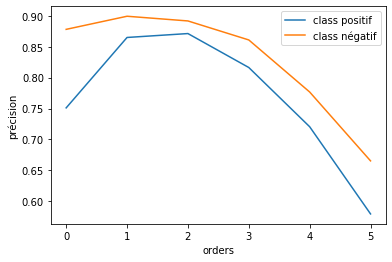

In [19]:
from collections import *
import matplotlib.pyplot as plt

# pour chaque document "propre" et segmenté, on créé un String qui contient tout les mots séparé d'un espace
for type_dataset in dictionnaire:
    for sentiment_type in dictionnaire[type_dataset]:
        for id_review in dictionnaire[type_dataset][sentiment_type]:
            review = dictionnaire[type_dataset][sentiment_type][id_review]["review"]
            dictionnaire[type_dataset][sentiment_type][id_review]["review_str"] = " ".join(review)

# pour chaque document "brut" (un unique String) on créé une segmentation en fonction des espaces
for type_dataset in init_dictionnaire:
    for sentiment_type in init_dictionnaire[type_dataset]:
        for id_review in init_dictionnaire[type_dataset][sentiment_type]:
            review = init_dictionnaire[type_dataset][sentiment_type][id_review]["review_str"]
            review = review.translate ({ord(c): " " for c in "!@#$%^&*()[]{};:,./?\|`~-=_+"})
            init_dictionnaire[type_dataset][sentiment_type][id_review]["review"] = review.split()

# Ainsi, chaque dictionnaire (celui dont on a traité les documents et celui comportant les documents "bruts")
# vont comporter leurs documents en une version segmentée et un version sous forme d'un grand String

# Nous nous concentrons sur les n_grammes de mots en nous inspirant du code donné par l'article
def train_words_lm(documents_lists, order=3):
    lm = defaultdict(Counter)
    # on compte les fréquences des mots
    for review_index in documents_lists:
        if "review" not in documents_lists[review_index]:
            print(documents_lists[review_index])
        review = documents_lists[review_index]["review"]
        for i in range(len(review)-order):
            history, word = review[i:i+order], review[i+order]
            lm[tuple(history)][word]+=1
    # cette fonction va nous servire à déterminer les probabilitées associées à chaque n-gramme
    def normalize(counter):
        s = float(sum(counter.values()))
        unsmooth = {}
        # pour toute les probabilitées, nous nous servons du logarithme de base 10 pour éviter les erreurs d'arrondie
        for c,cnt in counter.items():
            # on calcule la probabilité avec la formule de lissage de laplace
            unsmooth[c] = math.log((cnt + 1)/(s + taille_voc))
        # on applique la cas où le mot n'existe pas
        unsmooth["not_found"] = math.log(1/(s + taille_voc))
        return unsmooth
    outlm = {hist:normalize(words) for hist, words in lm.items()}
    # on applique la cas où le contexte n'existe pas
    outlm["not_found"] = math.log(1 / int(taille_voc))
    return outlm

lm_pos = train_words_lm(dictionnaire["train"]["pos"])
lm_neg = train_words_lm(dictionnaire["train"]["neg"])

# On s'inspire grandement du code fournis dans l'article
def calcul_proba(document, lm, order=3):
    proba = 0
    for i in range(len(document) - order):
        history, word = tuple(document[i:i+order]), document[i+order]
        if history in lm:
            if word in lm[history]:
                proba += lm[history][word] 
            else:
                proba += lm[history]["not_found"]
        else:
            proba += lm["not_found"]
    return proba

print("exemple: ")
print("P(test positif | lm_pos): " + str(calcul_proba(dictionnaire["test"]["pos"][10]["review"], lm_pos)))
print("P(test positif | lm_neg): " + str(calcul_proba(dictionnaire["test"]["pos"][10]["review"], lm_neg)))
print("P(test negatif | lm_pos): " + str(calcul_proba(dictionnaire["test"]["neg"][10]["review"], lm_pos)))
print("P(test negatif | lm_neg): " + str(calcul_proba(dictionnaire["test"]["neg"][10]["review"], lm_neg)))
# variables qui serviront à l'affichage
pos = []
neg = []
# nombre d'ordre que nous testerons
n = 5
print("\nsur le dictionnaire initial:")
for i in range(n + 1):
    # on entraine nos deux modèles de langues
    lm_pos = train_words_lm(init_dictionnaire["train"]["pos"], i)
    lm_neg = train_words_lm(init_dictionnaire["train"]["neg"], i)
    for classe in init_dictionnaire["train"]:
        class_by_index = []
        nb_pos = 0
        # on prédit pour chaque document si il est positif ou négatif
        for index_doc in range(len(dictionnaire["test"][classe])):
            proba_pos = calcul_proba(init_dictionnaire["test"][classe][index_doc]["review"], lm_pos, i)
            proba_neg = calcul_proba(init_dictionnaire["test"][classe][index_doc]["review"], lm_neg, i)
            
            if proba_pos > proba_neg:
                nb_pos += 1
                class_by_index.append(1)
            else:
                class_by_index.append(0)
        
        # on stock l'information pour l'affichage
        if classe == "pos": pos.append(nb_pos / len(class_by_index))
        else: neg.append((len(class_by_index) - nb_pos) / len(class_by_index))
        
plt.plot(pos, label="class positif")
plt.plot(neg, label="class négatif")
plt.xlabel('orders')
plt.ylabel('précision')
plt.legend()
plt.show()

Le principe est ici exactement le même, mais nous avons utilisé cette fois ci des n-grammes de lettres

In [29]:
def train_char_lm(data, order=4):
    lm = defaultdict(Counter)
    voc = set()
    for review_index in data:
        review = data[review_index]["review_str"]
        # comme dans l'article on marque le début d'un document
        pad = "~" * order
        padded_review = pad + review
        for i in range(len(padded_review) - order):
            history, char = padded_review[i:i + order], padded_review[i + order]
            if char not in voc: voc.add(char)
            lm[history][char] += 1

    def normalize(counter):
        s = float(sum(counter.values()))
        unsmooth = {}
        for c, cnt in counter.items():
            unsmooth[c] = math.log((cnt + 1) / (s + len(voc)))
        unsmooth["not_found"] = math.log(1 / (s + len(voc)))
        return unsmooth

    outlm = {hist: normalize(chars) for hist, chars in lm.items()}
    outlm["not_found"] = math.log(1 / len(voc))
    return outlm


def calcul_proba_char(document, lm, order=3):
    proba = 0
    for i in range(len(document) - order):
        history, word = document[i:i + order], document[i + order]
        if history in lm:
            if word in lm[history]:
                proba += lm[history][word]
            else:
                proba += lm[history]["not_found"]
        else:
            proba += lm["not_found"]
    return proba
# on crée un dictionnaire pour stocker nos prédictions
pred = {
    "clean" : { "pos": {}, 
              "neg": {}},
    "raw": { "pos": {}, 
              "neg": {}}
       }

pos = []
neg = []
print("sur le dictionnaire propre")
n = 10
for i in range(3, n):
    lm_pos = train_char_lm(dictionnaire["train"]["pos"], i)
    lm_neg = train_char_lm(dictionnaire["train"]["neg"], i)
    for classe in init_dictionnaire["train"]:
        pred["clean"][classe][i] = []
        class_by_index = []
        nb_pos = 0
        for index_doc in range(len(dictionnaire["test"]["pos"])):
            proba_pos = calcul_proba_char(dictionnaire["test"][classe][index_doc]["review_str"], lm_pos, i)
            proba_neg = calcul_proba_char(dictionnaire["test"][classe][index_doc]["review_str"], lm_neg, i)
            if proba_pos > proba_neg:
                nb_pos += 1
                pred["clean"][classe][i].append(1)
            else:
                pred["clean"][classe][i].append(0)

        if classe == "pos":
            pos.append(nb_pos / len(dictionnaire["test"]["pos"]))
        else: 
            neg.append((len(dictionnaire["test"]["pos"]) - nb_pos) / len(dictionnaire["test"]["pos"]))

plt.plot(list(range(3,n)),pos, label="class positif")
plt.plot(list(range(3,n)),neg, label="class négatif")
plt.xlabel('orders')
plt.ylabel('précision')
plt.legend()
plt.show()


pos = []
neg = []
print("\nsur le dictionnaire sans modification:")
for i in range(3, n):
    class_by_index = []
    nb_pos = 0
    lm_pos = train_char_lm(init_dictionnaire["train"]["pos"], i)
    lm_neg = train_char_lm(init_dictionnaire["train"]["neg"], i)
    for classe in init_dictionnaire["train"]:
        pred["raw"][classe][i] = []
        class_by_index = []
        nb_pos = 0
        for index_doc in range(len(dictionnaire["test"][classe])):
            proba_pos = calcul_proba_char(init_dictionnaire["test"][classe][index_doc]["review_str"], lm_pos, i)
            proba_neg = calcul_proba_char(init_dictionnaire["test"][classe][index_doc]["review_str"], lm_neg, i)
            if proba_pos > proba_neg:
                nb_pos += 1
                pred["raw"][classe][i].append(1)
            else:
                pred["raw"][classe][i].append(0)

        if classe == "pos":
            pos.append(nb_pos / len(dictionnaire["test"]["pos"]))
        else:
            neg.append((len(dictionnaire["test"]["pos"]) - nb_pos) / len(dictionnaire["test"]["pos"]))        

plt.plot(list(range(3,n)), pos, label="class positif")
plt.plot(list(range(3,n)),neg, label="class négatif")
plt.xlabel('orders')
plt.ylabel('précision')
plt.legend()
plt.show()


sur le dictionnaire propre


KeyboardInterrupt: 

## 5. Classification de documents avec sac de mots et Naive Bayes

Ici, vous utiliserez l'algorithme Multinomial Naive Bayes (disponible dans [`sklearn.naive_bayes.MultinomialNB`](https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.MultinomialNB.html)) pour classifier les documents. Vous utiliserez un modèle sac de mots (en anglais *bag of words*, ou BoW) avec TF-IDF pour représenter vos documents.

*Note :* vous avez déjà construit la matrice TF-IDF à la section 2.1.

In [ ]:
from sklearn.naive_bayes import MultinomialNB


# y = 0:pos 1:neg
X_test = TFIDF_BoW[0:25000][:]
y_test_nb = np.full((1, 12500), 0)
y_test_nb = np.append(y_test_nb, np.full((1, 12500), 1))

X_train = TFIDF_BoW[25000:][:]
y_train = np.full((1, 12500), 0)
y_train = np.append(y_train, np.full((1, 12500), 1))
            
classifier = MultinomialNB()
classifier.fit(X_train, y_train)
y_pred_nb = classifier.predict(X_test)
print(y_pred_nb)

## 6. Améliorations

Ici, vous devez proposer une méthode d'amélioration pour le modèle précédent, la justifier et l'implémenter.

*-> Écrivez vos explications ici <-*

## 7. Évaluation

Évaluation des modèles des sections 4, 5, 6 sur les données de test. On attend les métriques suivantes : *accuracy*, et pour chaque classe précision, rappel, score F1. Vous pourrez utiliser le module [`sklearn.metrics`](https://scikit-learn.org/stable/modules/classes.html#module-sklearn.metrics).

In [ ]:
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score

# accuracy
print("Accuracy NB:")
print(accuracy_score(y_test_nb, y_pred_nb))

# precision
print("Precision NB:")
print(precision_score(y_test_nb, y_pred_nb, average='binary'))

# recall
print("Recall NB:")
print(recall_score(y_test_nb, y_pred_nb, average='binary'))

# F1-score
print("F1-score NB:")
print(f1_score(y_test_nb, y_pred_nb, average='binary'))

Commentez vos résultats.

*-> Commentez ici vos résultats <-*